In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns  
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# Constants
SIZE = 32
BATCH_SIZE = 20
EPOCHS = 50

# Load dataset
skin_df = pd.read_csv('/Python/Ham10000/archive/HAM10000_metadata.csv')


In [3]:

# Label encoding
le = LabelEncoder()
le.fit(skin_df['dx'])
skin_df['label'] = le.transform(skin_df["dx"]) 

# Balancing the dataset
n_samples = 500 
skin_df_balanced = pd.concat([
    resample(skin_df[skin_df['label'] == i], replace=True, n_samples=n_samples, random_state=42) 
    for i in range(7)
])


In [4]:
# Load images
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('D://Python/Ham10000/archive/', '*', '*.jpg'))}
skin_df_balanced['path'] = skin_df_balanced['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))

# Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist()) / 255.0  # Scale values to 0-1
Y = skin_df_balanced['label']
Y_cat = to_categorical(Y, num_classes=7)  # Convert to categorical

# Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)



In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [6]:
# Define the model
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))


C:\Users\ganes\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('my_model.keras', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=2)


Epoch 1/50
132/132 - 26s - 196ms/step - acc: 0.7448 - loss: 0.6573 - val_acc: 0.6891 - val_loss: 0.9508
Epoch 2/50
132/132 - 19s - 147ms/step - acc: 0.7436 - loss: 0.6798 - val_acc: 0.6034 - val_loss: 1.4635
Epoch 3/50
132/132 - 20s - 154ms/step - acc: 0.7615 - loss: 0.6244 - val_acc: 0.6709 - val_loss: 0.9833
Epoch 4/50
132/132 - 19s - 141ms/step - acc: 0.7512 - loss: 0.6537 - val_acc: 0.5349 - val_loss: 1.5979
Epoch 5/50
132/132 - 19s - 145ms/step - acc: 0.7478 - loss: 0.6630 - val_acc: 0.7451 - val_loss: 0.7475
Epoch 6/50
132/132 - 20s - 153ms/step - acc: 0.7425 - loss: 0.6922 - val_acc: 0.7371 - val_loss: 0.7875
Epoch 7/50
132/132 - 20s - 155ms/step - acc: 0.7516 - loss: 0.6730 - val_acc: 0.7063 - val_loss: 0.8872
Epoch 8/50
132/132 - 19s - 147ms/step - acc: 0.7474 - loss: 0.6674 - val_acc: 0.6423 - val_loss: 1.1856
Epoch 9/50
132/132 - 21s - 156ms/step - acc: 0.7566 - loss: 0.6652 - val_acc: 0.7257 - val_loss: 0.8099
Epoch 10/50
132/132 - 19s - 148ms/step - acc: 0.7585 - loss: 0.6

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - acc: 0.7183 - loss: 0.8172
Test accuracy: 0.7279999852180481
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


<Axes: >

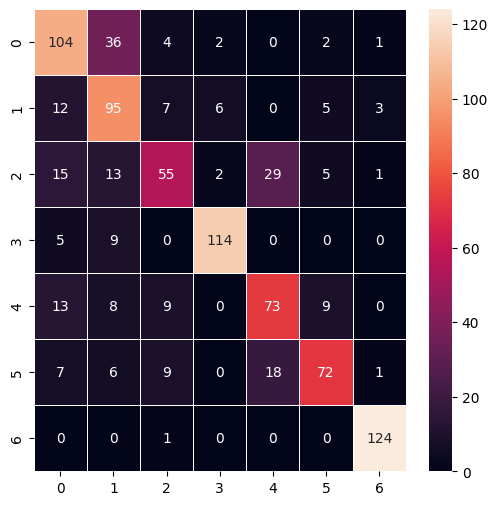

In [30]:

# Evaluate the model
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

# Prediction on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, ax=ax)


In [31]:
model.save("model.keras", include_optimizer=True)

In [32]:
model.save("skin_disease_model.h5", include_optimizer=True)

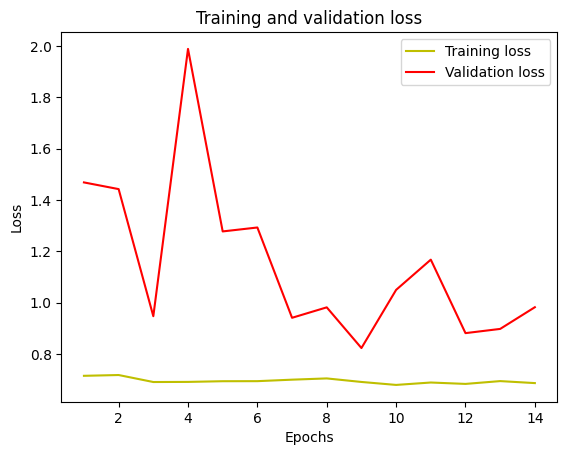

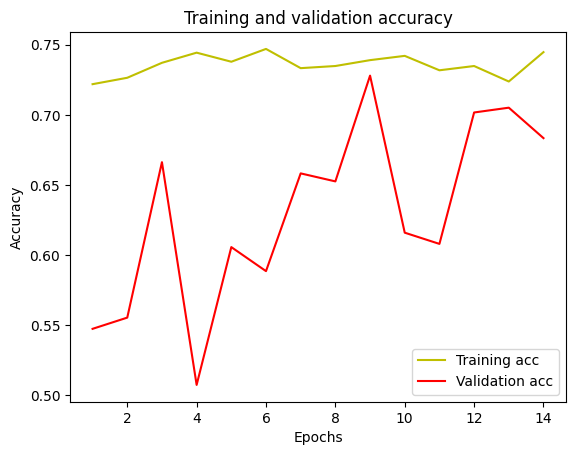

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# Function to predict the class of the image
def predict_image(image_path):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]
    return predicted_class

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((SIZE, SIZE))  # Resize to SIZE x SIZE
    img = np.asarray(img) / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [12]:
# Example usage
image_path = 'akiec.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class: akiec


In [13]:
# Example usage
image_path = 'akiec1.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted class: akiec


In [26]:
# Example usage
image_path = 'mel.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted class: vasc


In [27]:
# Example usage
image_path = 'mel1.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted class: vasc


In [16]:
# Example usage
image_path = 'vasc.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted class: vasc


In [17]:
# Example usage
image_path = 'vasc1.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted class: vasc


In [18]:
# Example usage
image_path = 'nv.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted class: nv


In [19]:
# Example usage
image_path = 'df1.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted class: df


In [28]:
# Example usage
image_path = 'bcc1.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class:{class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted class:df


In [21]:
# Example usage
image_path = 'bkl1.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted class: bkl


In [22]:
# Example usage
image_path = 'nv1.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted class: mel


In [23]:
# Example usage
image_path = 'bkl.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted class: bkl


In [24]:
# Example usage
image_path = 'bcc.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted class: df


In [25]:
# Example usage
image_path = 'df.jpg'
predicted_class = predict_image(image_path)
class_names = le.classes_  # Use the same label encoder classes
print(f'Predicted class: {class_names[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted class: df


In [ ]:
nv,df1,bcc1,bkl1

In [ ]:
mel,vasc,akiec

In [ ]:
nv1,bcc,bkl

In [ ]:
df

In [ ]:
Actinic keratosis:
This condition causes a thick, scaly, or crusty skin patch.
It’s typically less than 2 cmTrusted Source or about the size of a pencil eraser.
It often appears on parts of the body that receive a lot of sun exposure, such as the hands, arms, face, scalp, and neck.
The skin patch is usually pink in color but can have a brown, tan, or gray base. This patch may appear the same color as the surrounding skin in people with darker skin.

In [ ]:
Basal cell carcinoma:
It can cause dome-like, pink or red, shiny, and pearly areas that may have a sunk-in center, like a crater. For people with dark skin, it might appear darker and less pearly.
This condition is often characterized by raised, firm, and pale areas that may resembleTrusted Source a scar.
Blood vessels on the growth may be visible.
It might cause easy bleeding or an oozing wound that doesn’t seem to heal, or it heals and then reappears.

In [ ]:
Melanoma:
This is the most seriousTrusted Source form of skin cancer, which is more common in people with light skin.
It can appear anywhere on the body as a mole that has irregularly shaped edges, asymmetrical shapes, and multiple colors. In People of Color, melanoma often appears in areas that are less exposed to the sun.
It might also appear as a mole that has changed color or gotten bigger over time, which is usually larger than a pencil eraser.

Text(0.5, 0.98, 'actinic keratosis')

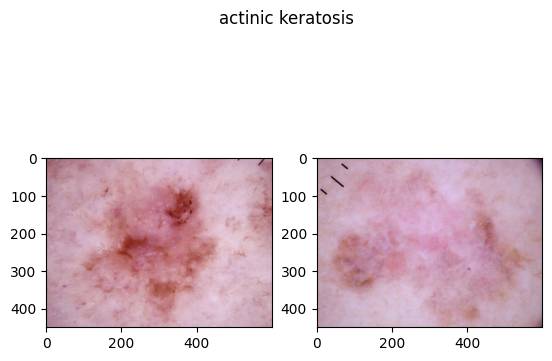

In [29]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
fig1,(a1,a2)=plt.subplots(1,2)

a1.imshow(mpimg.imread('akiec.jpg'))

a2.imshow(mpimg.imread('akiec1.jpg'))



fig1.suptitle('actinic keratosis')


Text(0.5, 0.98, 'basal cell carcinoma')

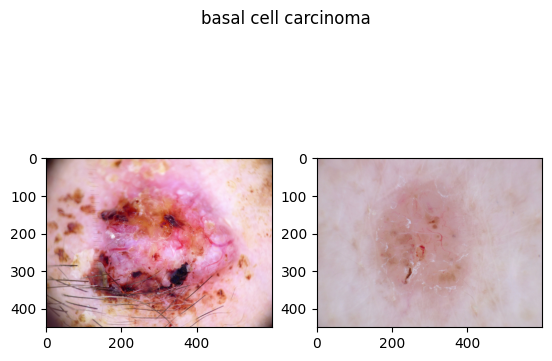

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
fig1,(a1,a2)=plt.subplots(1,2)

a1.imshow(mpimg.imread('bcc.jpg'))

a2.imshow(mpimg.imread('bcc1.jpg'))



fig1.suptitle('basal cell carcinoma')


Text(0.5, 0.98, 'pigmented benign keratosis')

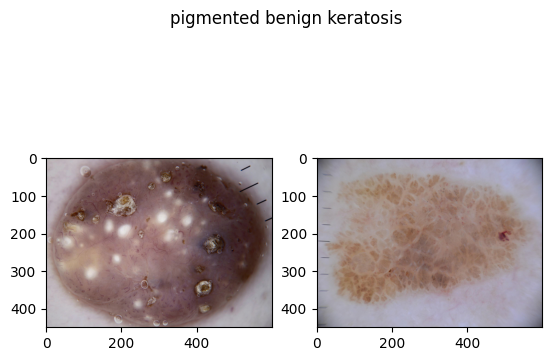

In [31]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
fig1,(a1,a2)=plt.subplots(1,2)

a1.imshow(mpimg.imread('bkl.jpg'))

a2.imshow(mpimg.imread('bkl1.jpg'))



fig1.suptitle('pigmented benign keratosis')


Text(0.5, 0.98, 'dermatofibroma')

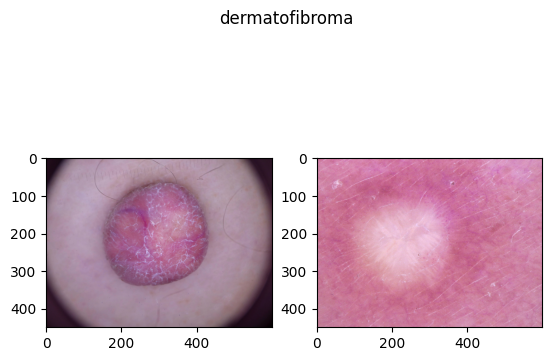

In [32]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
fig1,(a1,a2)=plt.subplots(1,2)

a1.imshow(mpimg.imread('df.jpg'))

a2.imshow(mpimg.imread('df1.jpg'))



fig1.suptitle('dermatofibroma')


Text(0.5, 0.98, 'melanoma')

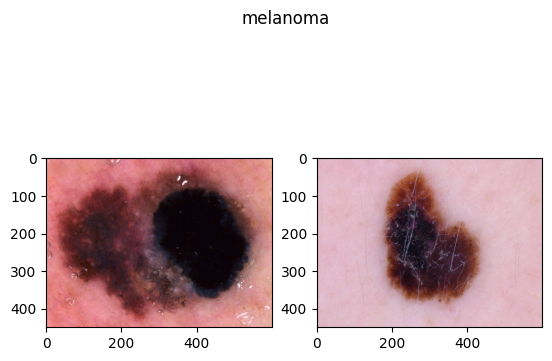

In [33]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
fig1,(a1,a2)=plt.subplots(1,2)

a1.imshow(mpimg.imread('mel.jpg'))

a2.imshow(mpimg.imread('mel1.jpg'))



fig1.suptitle('melanoma')


Text(0.5, 0.98, 'nevus')

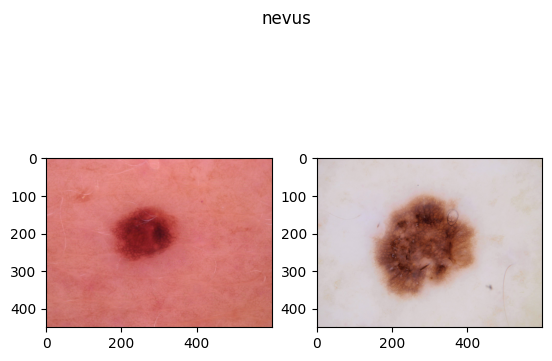

In [34]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
fig1,(a1,a2)=plt.subplots(1,2)

a1.imshow(mpimg.imread('nv.jpg'))

a2.imshow(mpimg.imread('nv1.jpg'))



fig1.suptitle('nevus')


Text(0.5, 0.98, 'vascular lesion')

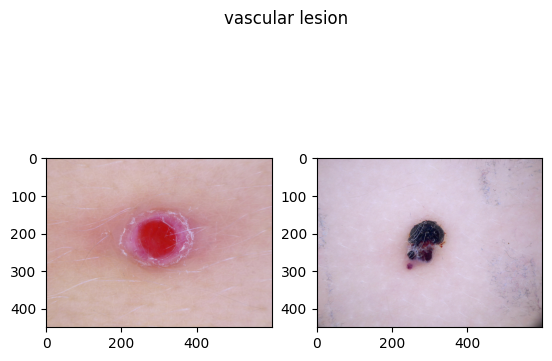

In [35]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
fig1,(a1,a2)=plt.subplots(1,2)

a1.imshow(mpimg.imread('vasc.jpg'))

a2.imshow(mpimg.imread('vasc1.jpg'))



fig1.suptitle('vascular lesion')
